In [1]:
from random import random
from numpy import log, sqrt, exp, argmin, percentile
from enum import Enum
from heapq import heappush, heappop, heapify
from collections import deque
from statistics import mean, stdev
from abc import ABC, abstractmethod
from scipy.stats import expon, chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Implementación de los Algoritmos
#### Ejercicicio 1a) y 2a)
Como se explicó en el informe, las resoluciones de los ejercicios 1 y 2 varían ligeramente en la implementación de los métodos *handle_incoming_customer* y *handle_outgoing_customer*. Debido a esto, se decidió usar una clase abstracta que implementará los métodos compartidos de ambas soluciones.

In [2]:
def ε(λ):
    """
    Returns a value of an exponential r.v. of rate λ
    """
    return -log(1 - random()) / λ


def poisson_process_Σε(λ, nof_arrivals):
    """
    Generates the first @nof_arrivals samples of an homogeneous poisson process
    of rate @λ.
    """
    t = ε(λ)
    arrival_times = []
    while len(arrival_times) < nof_arrivals:
        arrival_times.append(t)
        t += ε(λ)
    return arrival_times


class Customer:
    """
    Customer class which keeps track of its arrival and departure time.
    """
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.departure_time = None


class ATM:
    """
    ATM class which keeps track of its service rate, and the number of customers
    it attended.
    """
    def __init__(self, id, service_rate):
        self.id = id
        self.service_rate = service_rate
        self.is_busy = False
        self.attended_customers = 0

    def attend_customer(self, simtime, customer):
        """
        Given a @customer, assigns when it departures by time @simtime and
        increment by 1 the number of customer who passed through this ATM.
        """
        customer.departure_time = simtime + ε(self.service_rate)
        self.is_busy = True
        self.attended_customers += 1

In [3]:
class BaseATMSimulator(ABC):
    """
    Abstract Base class for the Simulation Runner
    """

    Event = Enum('Event', 'ARRIVAL DEPARTURE')

    def __init__(self, λ, λs, nof_arrivals):
        self.λ = λ
        self.λs = λs
        self.nof_arrivals = nof_arrivals
        self.simtime = 0
        self.atms = []
        self.customers = []
        self.events = []

    @abstractmethod
    def handle_incoming_customer(self, customer):
        """
        Abstract method controller for handling customer arrivals.
        """
        pass

    @abstractmethod
    def handle_outgoing_customer(self, atm):
        """
        Abstract method controller for handling customer departures.
        """
        pass

    def set_up(self):
        """
        Enqueues all the events of type arrival, and instantiates the ATMs and
        customers to be used in a simulation run.
        """
        self.simtime = 0
        self.atms = [
            ATM(id, service_rate)
            for id, service_rate in zip(range(len(self.λs)), self.λs)
        ]
        self.customers = []
        self.events = []

        arrival_times = poisson_process_Σε(self.λ, self.nof_arrivals)
        self.customers = [Customer(time) for time in arrival_times]
        self.events = [
            (time, self.Event.ARRIVAL, customer)
            for time, customer in zip(arrival_times, self.customers)
        ]
        heapify(self.events)

    def run(self):
        """
        Simulates the departure time of @self.nof_arrivals customers and the
        number of them who were attended by each atm.
        """
        self.set_up()
        while len(self.events) > 0:
            time, event, obj = heappop(self.events)
            self.simtime = time
            if event is self.Event.ARRIVAL:
                self.handle_incoming_customer(obj)
            elif event is self.Event.DEPARTURE:
                self.handle_outgoing_customer(obj)

    def yield_waiting_time_results(self):
        """
        Returns samples of the r.v. defined as the customer waiting time in the
        system and an estimate of μ and σ.
        """
        ws = [
            customer.departure_time - customer.arrival_time
            for customer in self.customers
        ]
        return ws, mean(ws), stdev(ws)

    def yield_proportion_results(self):
        """
        Returns a proportion estimate of the attended customers by each atm
        """
        return [atm.attended_customers / self.nof_arrivals for atm in self.atms]

    def save_histogram(self, filename="histogram.png", only_show=False, norm=False):
        """
        Saves an histogram by means of the customer waiting samples obtained
        after simulating their departure times. If @norm is True, it plots the
        normalized histogram of the sample and compares it with an exponential
        distribution of rate λ = 1.
        """
        ws, w̅, s = self.yield_waiting_time_results()
        nof_digits = 3
        nof_bins = 100

        fig, ax = plt.subplots(figsize=(14, 7))
        n, bins, patches = plt.hist(
            ws,
            bins=nof_bins,
            facecolor='#2ab0ff',
            edgecolor='#e0e0e0',
            density=norm,
            linewidth=0.5,
            alpha=0.7,
        )
        if norm:
            ax.plot(bins, expon.pdf(bins), 'r-', lw=5, alpha=0.6, label='expon pdf')
            ax.legend(loc='best', frameon=False)
        else:
            n = n.astype('int')
            for i in range(len(patches)):
                patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

        ax.annotate(
            (f'μ ≅ {round(w̅, nof_digits)} - '
             f'σ ≅ {round(s, nof_digits)} - '
             f'nof_arrivals = {self.nof_arrivals}'),
            xy=(0.85, 0.85),
            xycoords='figure fraction',
            va='top',
            ha='right',
            bbox=dict(boxstyle='round', fc='w')
        )
        ax.set_xlabel('Tiempo de Espera (min)')
        ax.set_ylabel('Frequencia')
        ax.set_title('Histograma del Tiempo que los Cliente Pasan en el Sistema')

        plt.grid()
        plt.show() if only_show else plt.savefig(filename)
        plt.close()

    def save_proportion_pie(self, filename="pie.png", only_show=False):
        """
        Saves a proportion pie by means of the proportion samples obtained after
        running the method @run.
        """
        ps = self.yield_proportion_results()
        nof_slices = len(ps)
        labels = [f'ATM {id + 1}' for id in range(nof_slices)]
        explode = [0] * nof_slices
        explode[0] = 0.1    # Explode ATM 0

        fig, ax = plt.subplots(figsize=(14, 7))
        ax.pie(
            ps,
            explode=explode,
            labels=labels,
            autopct='%1.1f%%',
            shadow=True,
            startangle=90
        )
        ax.set_title('Proporción de Clientes Atendidos por ATM')
        ax.axis('equal')

        plt.show() if only_show else plt.savefig(filename)
        plt.close()

In [4]:
class SQueueATMSimulator(BaseATMSimulator):
    """
    Simulation Runner of a single-queue parallel ATM system.
    """
    def __init__(self, λ, λs, nof_arrivals):
        super().__init__(λ, λs, nof_arrivals)
        self.queue = deque()

    def handle_incoming_customer(self, customer):
        """
        Enqueues a @customer if the main queue is not empty or all atms are
        being used. Otherwise it assigns him a free atm whose id is the smallest
        and enqueues his departure event.
        """
        free_atms = [atm for atm in self.atms if not atm.is_busy]
        if len(self.queue) > 0 or len(free_atms) == 0:
            self.queue.append(customer)
        else:
            atm = free_atms[0]
            atm.attend_customer(self.simtime, customer)
            heappush(
                self.events,
                (customer.departure_time, self.Event.DEPARTURE, atm)
            )

    def handle_outgoing_customer(self, atm):
        """
        If the main queue is not empty, assigns the first-come customer to the
        atm which has just been freed and queues its departure event. Otherwise,
        marks the atm as unused.
        """
        if len(self.queue) > 0:
            customer = self.queue.popleft()
            atm.attend_customer(self.simtime, customer)
            heappush(
                self.events,
                (customer.departure_time, self.Event.DEPARTURE, atm)
            )
        else:
            atm.is_busy = False

In [5]:
class MQueueATMSimulator(BaseATMSimulator):
    """
    Simulation Runner of a multi-queue parallel ATM system.
    """
    def __init__(self, λ, λs, nsim):
        super().__init__(λ, λs, nsim)
        self.queues = [deque() for _ in λs]

    def shortest_queue(self):
        """
        Returns the lowest numbered shortest queue and its corresponding atm.
        """
        idx = argmin([len(queue) for queue in self.queues])  # Only the first ocurrence is returned
        shortest_queue = self.queues[idx]
        atm = self.atms[idx]
        return shortest_queue, atm

    def handle_incoming_customer(self, customer):
        """
        Enqueues a @customer if it the shortest queue is not empty or
        its atm is being used. Otherwise it assigns that atm and
        enqueues his departure event.
        """
        queue, atm = self.shortest_queue()
        if len(queue) > 0 or atm.is_busy:
            queue.append(customer)
        else:
            atm.attend_customer(self.simtime, customer)
            heappush(
                self.events,
                (customer.departure_time, self.Event.DEPARTURE, atm)
            )

    def handle_outgoing_customer(self, atm):
        """
        Given an @atm which has just been freed, it assigns the first-come
        customer to it and queues its departure time as long as its queue is
        not empty. Otherwise, marks the atm as unused.
        """
        queue = self.queues[atm.id]
        if len(queue) > 0:
            customer = queue.popleft()
            atm.attend_customer(self.simtime, customer)
            heappush(
                self.events,
                (customer.departure_time, self.Event.DEPARTURE, atm)
            )
        else:
            atm.is_busy = False

### Resultados de la Simulación y Resolución de Ejercicios

#### Ejercicio 1b)

In [6]:
def ej1b():
    λ, λs, nof_arrivals = 6, [4, 3], 1000

    runner = SQueueATMSimulator(λ, λs, nof_arrivals)
    runner.run()
    ws, w̅, s = runner.yield_waiting_time_results()
    ps = runner.yield_proportion_results()

    percentiles = [20, 50, 80]
    print(f'μ ≅ {w̅}')
    print(f'σ ≅ {s}')
    for p in percentiles:
        print(f'Percentile {p} de los datos: {percentile(ws, p)}')
    for i in range(len(ps)):
        print(f'Proporción de clientes atendidos por ATM {i + 1} ≅ {ps[i]}')

ej1b()

μ ≅ 1.4331344294261015
σ ≅ 1.1892753554194255
Percentile 20 de los datos: 0.33527620156819327
Percentile 50 de los datos: 1.1753049912839586
Percentile 80 de los datos: 2.3765265382278202
Proporción de clientes atendidos por ATM 1 ≅ 0.598
Proporción de clientes atendidos por ATM 2 ≅ 0.402


#### Ejercicio 1c)

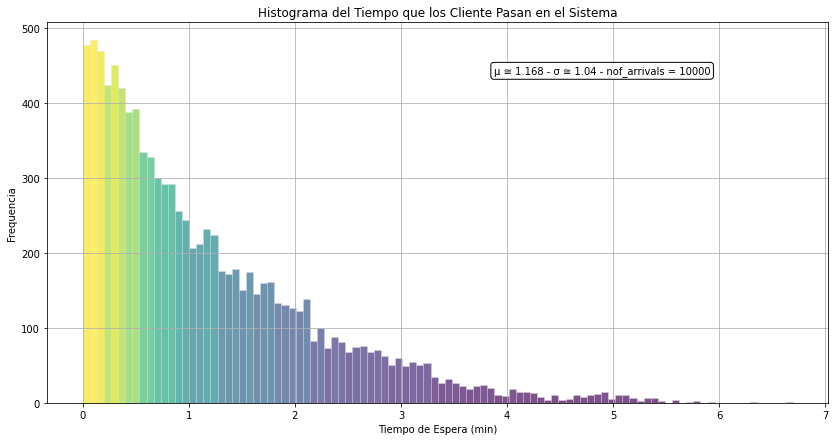

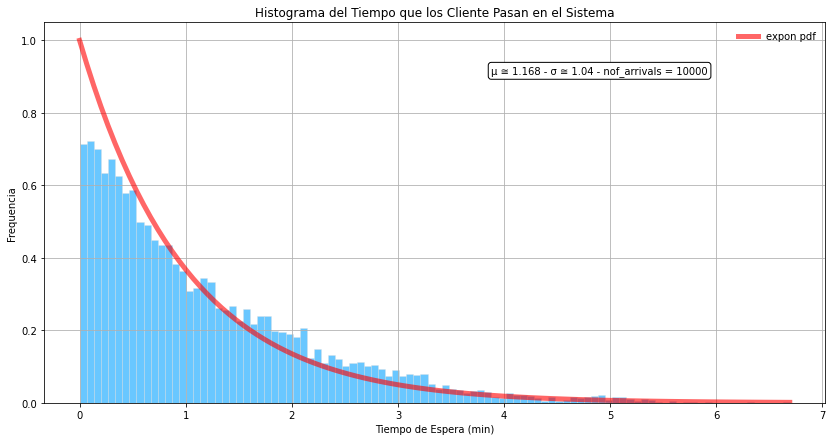

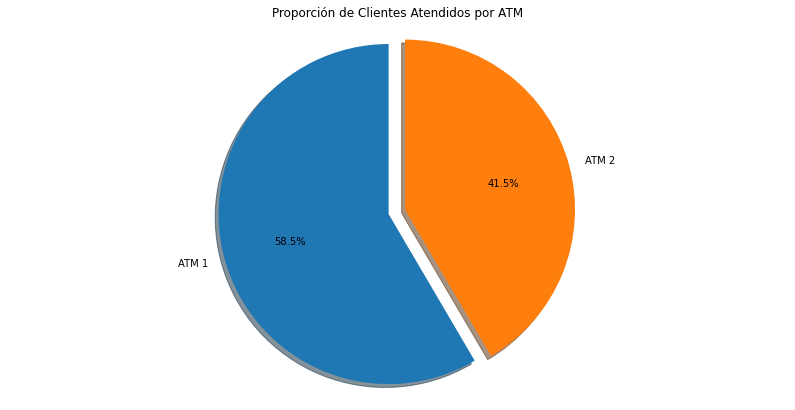

In [7]:
def ej1c():
    λ, λs, nof_arrivals = 6, [4, 3], 10000
    runner = SQueueATMSimulator(λ, λs, nof_arrivals)
    runner.run()
    runner.save_histogram(only_show=True)
    runner.save_histogram(only_show=True, norm=True)
    runner.save_proportion_pie(only_show=True)

ej1c()

#### Ejercicio 2b)

In [8]:
def ej2b():
    λ, λs, nof_arrivals = 6, [4, 3], 1000

    runner = MQueueATMSimulator(λ, λs, nof_arrivals)
    runner.run()

    ws, w̅, s = runner.yield_waiting_time_results()
    ps = runner.yield_proportion_results()

    percentiles = [20, 50, 80]
    print(f'μ ≅ {w̅}')
    print(f'σ ≅ {s}')
    for p in percentiles:
        print(f'Percentile {p} de los datos: {percentile(ws, p)}')
    for i in range(len(ps)):
        print(f'Proporción de clientes atendidos por ATM {i + 1} ≅ {ps[i]}')

ej2b()

μ ≅ 0.7925135124659031
σ ≅ 0.6800260874459331
Percentile 20 de los datos: 0.22402351481035793
Percentile 50 de los datos: 0.6364272318046531
Percentile 80 de los datos: 1.269751604715242
Proporción de clientes atendidos por ATM 1 ≅ 0.633
Proporción de clientes atendidos por ATM 2 ≅ 0.367


#### Ejercicio 2c)

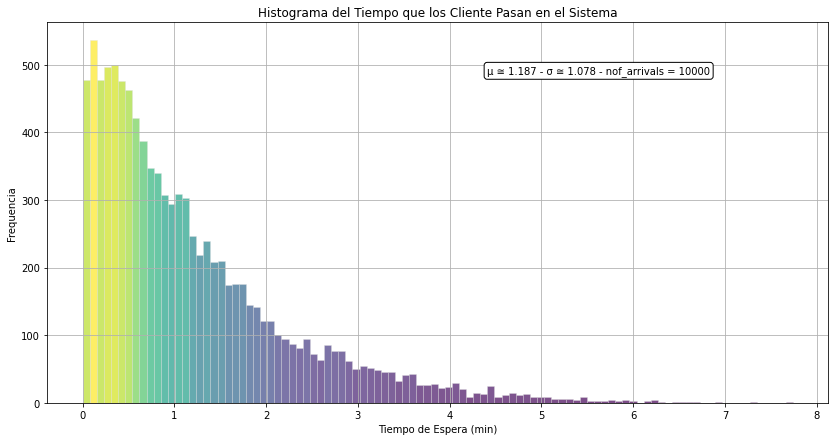

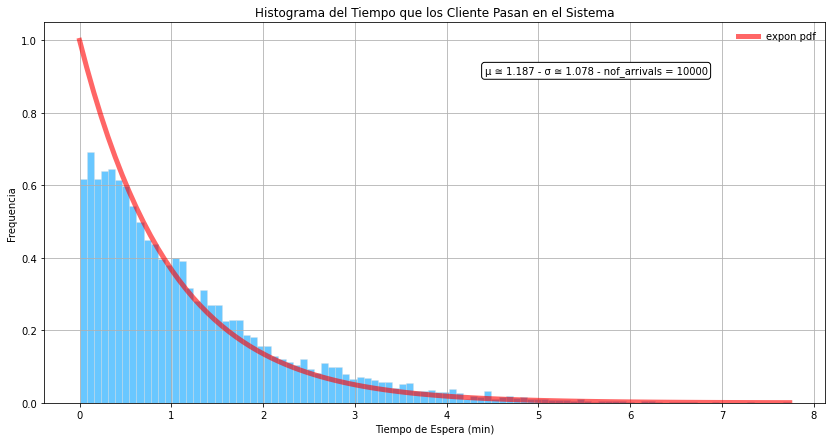

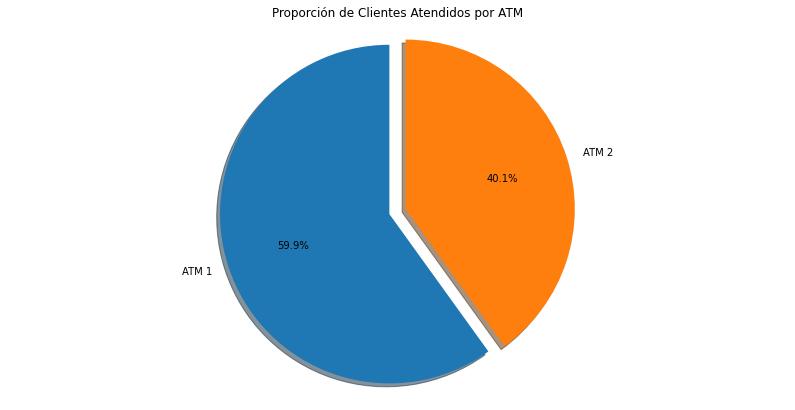

In [9]:
def ej2c():
    λ, λs, nof_arrivals = 6, [4, 3], 10000
    runner = MQueueATMSimulator(λ, λs, nof_arrivals)
    runner.run()
    runner.save_histogram(only_show=True)
    runner.save_histogram(only_show=True, norm=True)
    runner.save_proportion_pie(only_show=True)

ej2c()

### Implementación de Estadisticos y Test de Validación para v.a. Continuas
(Utilizados para los análisis de los datos obtenidos)

In [10]:
def D(xs):
    """
    Given a list @xs of samples evaluated in the cdf of the distribution under
    test, it returns the observed value of the Kolmogorov Smirnov statistic.
    """
    nof_samples = len(xs)
    observed_value = 0
    xs.sort()
    for x, j in zip(xs, range(nof_samples)):
        observed_value = max(
            observed_value,
            (j + 1)/nof_samples - x,
            x - j/nof_samples
        )
    return observed_value


def T(ns, ps, nof_samples):
    """
    Given lists @ns of observed frecuencies of the grouped sample and the real
    probability @ps of each group, it returns the observed value of the χ²
    statistic.
    """
    return sum([
        (frequency - nof_samples*prob)**2 /
        (nof_samples*prob)
        for frequency, prob in zip(ns, ps)
    ])


def kolmogorov_smirnov(nof_sim, nof_samples, d0):
    """
    Given the observed value of a sample after running the statistic D. It
    estimates the p-value by running @nof_sim simulations.
    """
    p_value = 0
    for _ in range(nof_sim):
        d = D([random() for _ in range(nof_samples)])
        if d >= d0:
            p_value += 1
    return p_value / nof_sim

#### Single-Queue: Test de validación sobre exponencial de parámetro λ = 1

In [11]:
def expon_test_sq():
    λ, λs, nof_arrivals = 6, [4, 3], 10000
    runner = SQueueATMSimulator(λ, λs, nof_arrivals)
    runner.run()
    ws, w̅, s = runner.yield_waiting_time_results()
    nof_sim = 1000
    nof_samples = len(ws)
    d0 = D([expon.cdf(w) for w in ws])
    p_value = kolmogorov_smirnov(nof_sim, nof_samples, d0)

    print(f'Valor observado d0 ≅ {d0}')
    print(f'p_value ≅ {p_value}')

expon_test_sq()

Valor observado d0 ≅ 0.09782150586594973
p_value ≅ 0.0


#### Multi-Queue: Test de validación sobre exponencial de parámetro λ = 1

In [12]:
def expon_test_mq():
    λ, λs, nof_arrivals = 6, [4, 3], 10000
    runner = MQueueATMSimulator(λ, λs, nof_arrivals)
    runner.run()
    ws, w̅, s = runner.yield_waiting_time_results()

    nof_sim = 1000
    nof_samples = len(ws)
    d0 = D([expon.cdf(w) for w in ws])
    p_value = kolmogorov_smirnov(nof_sim, nof_samples, d0)
    print(f'Valor observado d0 ≅ {d0}')
    print(f'p_value ≅ {p_value}')

expon_test_mq()

Valor observado d0 ≅ 0.03882118925775521
p_value ≅ 0.0


#### Single-Queue: Test de validación sobre Bernoulli de parámetro p = 4/7
Nota: Toma alrededor de 1min ejecutar las 1000 pruebas de 10000 arrivos.

In [13]:
def bernoulli_test_sq():
    λ, λs, nof_arrivals = 6, [4, 3], 10000
    runner = SQueueATMSimulator(λ, λs, nof_arrivals)
    
    nof_samples = nof_arrivals
    nof_groups = 2
    df = nof_groups - 1
    ps = [4/7, 3/7]
    trials = 1000
    nof_rejections = 0

    # Confidence (1 - α)*100%
    α = 0.05

    for i in range(trials):
        runner.run()
        ns = [p * nof_samples for p in runner.yield_proportion_results()]
        t0 = T(ns, ps, nof_samples)
        p_value = 1 - chi2.cdf(t0, df)
        if p_value < α:
            nof_rejections += 1
    print(f'Porcentage de Rechazos a la Hipotesis Nula: {(nof_rejections/trials) * 100}%')

bernoulli_test_sq()

Porcentage de Rechazos a la Hipotesis Nula: 43.3%


#### Multi-Queue: Test de validación sobre Bernoulli de parámetro p = 4/7
Nota: Toma alrededor de 1min ejecutar las 1000 pruebas de 10000 arrivos.

In [ ]:
def bernoulli_test_mq():
    λ, λs, nof_arrivals = 6, [4, 3], 10000
    runner = MQueueATMSimulator(λ, λs, nof_arrivals)
    nof_samples = nof_arrivals
    nof_groups = 2
    df = nof_groups - 1
    ps = [4/7, 3/7]

    trials = 1000
    nof_rejections = 0

    # Confidence (1 - α)*100%
    α = 0.05

    for _ in range(trials):
        runner.run()
        ns = [p * nof_samples for p in runner.yield_proportion_results()]
        t0 = T(ns, ps, nof_samples)
        p_value = 1 - chi2.cdf(t0, df)
        if p_value < α:
            nof_rejections += 1

    print(f'Porcentage de Rechazos a la Hipotesis Nula: {(nof_rejections/trials) * 100}%')

bernoulli_test_mq()